In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import warnings
warnings.filterwarnings('ignore')

# Catfish Sales Data

In [3]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [4]:
#read data
catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [5]:
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [6]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

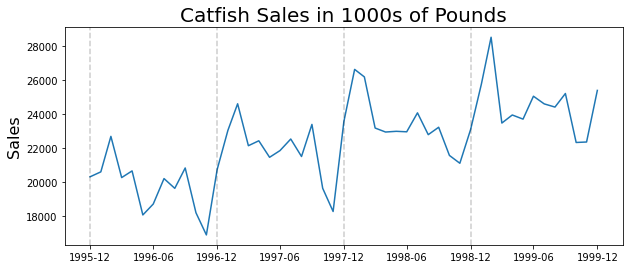

In [7]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [8]:
first_diff = lim_catfish_sales.diff()[1:]

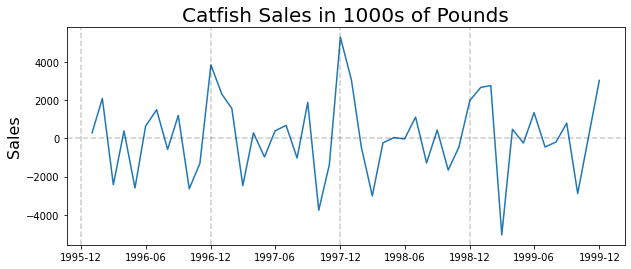

In [9]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

# ACF

<BarContainer object of 12 artists>

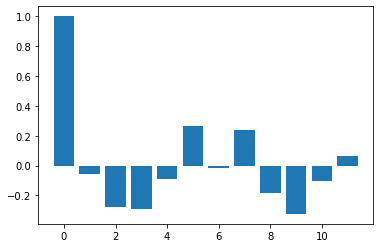

In [12]:
acf_vals = acf(first_diff)
num_lags = 12
plt.bar(range(num_lags), acf_vals[:num_lags])

## Based on ACF, we should start with a seasonal MA process

# PACF

<BarContainer object of 12 artists>

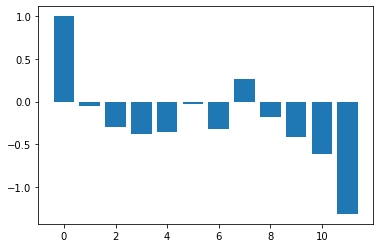

In [13]:
pacf_vals = pacf(first_diff)
num_lags = 12
plt.bar(range(num_lags), pacf_vals[:num_lags])

In [14]:
pacf_vals[:num_lags]

array([ 1.        , -0.05664512, -0.29598111, -0.38156786, -0.35192441,
       -0.03148149, -0.31964262,  0.26645711, -0.18465438, -0.41892152,
       -0.61504453, -1.31475811])

绝对值大于等于0.2的自相关系数或偏自相关系数可以被认为是显著的（即具有相关性），而绝对值小于0.2的自相关系数或偏自相关系数可以被认为是不显著的（即可能是白噪声）。

- 当自相关函数（ACF）或偏自相关函数（PACF）在滞后几期后快速下降，说明时间序列中存在显著的自相关性或部分自相关性，即时间序列是非随机的。
- 当自相关函数（ACF）或偏自相关函数（PACF）在滞后几期后几乎为零，说明时间序列中不存在显著的自相关性或部分自相关性，即时间序列是白噪声的，即没有任何相关性，所有的值都是随机噪声。

## Based on PACF, we should start with a seasonal AR process

# Get training and testing sets

In [15]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

train_data = lim_catfish_sales[:train_end]
test_data = lim_catfish_sales[train_end + timedelta(days=1):test_end]

# Fit the SARIMA Model

In [16]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [17]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.89920D+00    |proj g|=  1.35680D+00

At iterate    5    f=  8.55864D+00    |proj g|=  2.82664D-01

At iterate   10    f=  8.53795D+00    |proj g|=  1.36698D-03

At iterate   15    f=  8.53795D+00    |proj g|=  1.19740D-03

At iterate   20    f=  8.53785D+00    |proj g|=  1.51118D-02

At iterate   25    f=  8.52306D+00    |proj g|=  1.07976D-02

At iterate   30    f=  8.51675D+00    |proj g|=  1.44752D-02

At iterate   35    f=  8.50351D+00    |proj g|=  7.69844D-03


 This problem is unconstrained.



At iterate   40    f=  8.50313D+00    |proj g|=  2.52824D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     40     53      1     0     0   2.528D-05   8.503D+00
  F =   8.5031324810656024     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Model Fitting Time: 0.2827279567718506


In [18]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -365.635
Date:                              Sun, 02 Apr 2023   AIC                            737.269
Time:                                      20:55:21   BIC                            742.482
Sample:                                  01-01-1996   HQIC                           739.180
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8250      0.121      6.845      0.000       0.589       1.061
ma.S.L12      -0.51

In [19]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

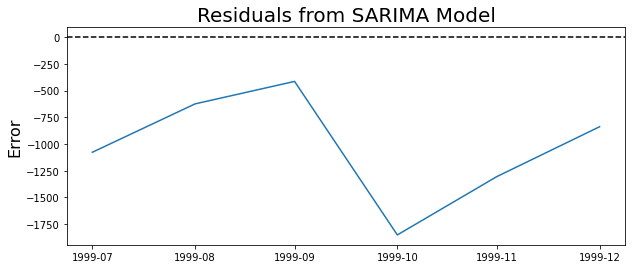

In [20]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

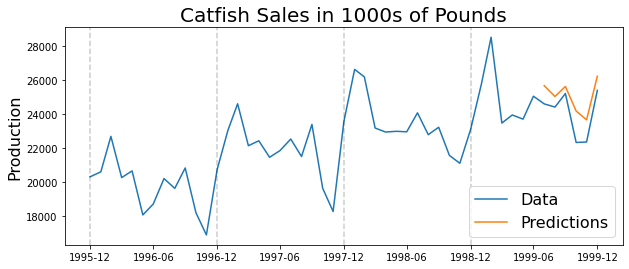

In [21]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [22]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0433


In [23]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1122.2814257651041


# Using the Rolling Forecast Origin

In [24]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_catfish_sales[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.89920D+00    |proj g|=  1.35680D+00

At iterate    5    f=  8.55864D+00    |proj g|=  2.82664D-01

At iterate   10    f=  8.53795D+00    |proj g|=  1.36698D-03

At iterate   15    f=  8.53795D+00    |proj g|=  1.19740D-03

At iterate   20    f=  8.53785D+00    |proj g|=  1.51118D-02

At iterate   25    f=  8.52306D+00    |proj g|=  1.07976D-02

At iterate   30    f=  8.51675D+00    |proj g|=  1.44752D-02

At iterate   35    f=  8.50351D+00    |proj g|=  7.69844D-03


 This problem is unconstrained.



At iterate   40    f=  8.50313D+00    |proj g|=  2.52824D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     40     53      1     0     0   2.528D-05   8.503D+00
  F =   8.5031324810656024     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.86054D+00    |proj g|=  1.17234D+00

At iterate    5    f=  8.58660D+00    |proj g|=  2.94982D-01

At iterate   10    f=  8.55995D+00    |proj g|=  1.27476D-03

At iter

 This problem is unconstrained.



At iterate   30    f=  8.51697D+00    |proj g|=  1.86832D-02

At iterate   35    f=  8.50221D+00    |proj g|=  5.16073D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     39     49      1     0     0   9.230D-06   8.502D+00
  F =   8.5017078635127277     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.30312D+00    |proj g|=  6.87409D-01

At iterate    5    f=  8.55398D+00    |proj g|=  2.46993D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  8.54181D+00    |proj g|=  1.80574D-03

At iterate   20    f=  8.54139D+00    |proj g|=  2.26811D-02

At iterate   25    f=  8.51841D+00    |proj g|=  1.19563D-01

At iterate   30    f=  8.49429D+00    |proj g|=  1.68051D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     47      1     0     0   3.812D-05   8.494D+00
  F =   8.4942659027359682     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.48792D+00    |proj g|=  2.99167D-03

At iterate   10    f=  8.48775D+00    |proj g|=  3.51203D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     13      1     0     0   6.317D-05   8.488D+00
  F =   8.4877521852444655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.94347D+00    |proj g|=  1.51127D+00

At iterate    5    f=  8.52598D+00    |proj g|=  2.30780D-01

At iter

 This problem is unconstrained.



At iterate    5    f=  8.51789D+00    |proj g|=  1.26761D-01

At iterate   10    f=  8.49455D+00    |proj g|=  1.38868D-03

At iterate   15    f=  8.49455D+00    |proj g|=  4.61676D-04

At iterate   20    f=  8.49448D+00    |proj g|=  2.34014D-03

At iterate   25    f=  8.49005D+00    |proj g|=  2.41134D-02

At iterate   30    f=  8.48362D+00    |proj g|=  3.24940D-03

At iterate   35    f=  8.48333D+00    |proj g|=  3.25802D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     35     41      1     0     0   3.258D-06   8.483D+00
  F =   8.4833339339785514     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

In [25]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

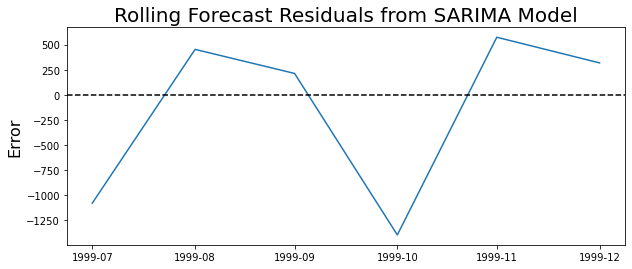

In [26]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

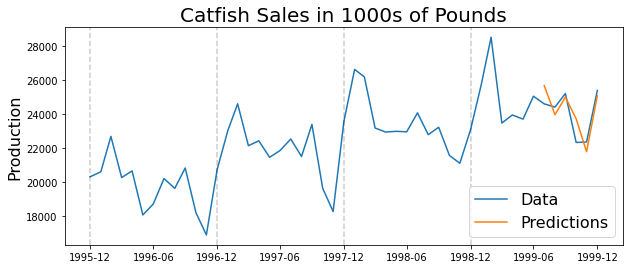

In [27]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [28]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0285


In [29]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 793.9048333602834
